In [1]:
import sys
import os

# Add the project root directory to sys.path
project_root = r'C:\Users\Ian Bracken\Desktop\WebDev\nba-prediction-model'
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import pickle
from postgres.config import SessionLocal
from postgres.models import AdvancedPlayerStats, ClusteredPlayers





In [3]:
session = SessionLocal()

players = session.query(AdvancedPlayerStats).all()
# Convert ORM objects to a list of dictionaries
data = []
for player in players:
    player_dict = {column.name: getattr(player, column.name) for column in player.__table__.columns}
    data.append(player_dict)

df = pd.DataFrame(data)

df.set_index('PLAYER', inplace=True)


df = df[df['GP'] >= 10]
df = df[df['MIN'] >= 15]
# Perhaps a poor practice and should remove them in the scraping algorithm
df = df.drop(columns=['id', 'TEAM', 'W', 'L', 'GP', 'DREB', 'STL', 'BLK'])
# df = df.astype(float)
df.head()

,AGE,MIN,OFFRTG,DEFRTG,NETRTG,AST_PERCENT,AST_TO,AST_RATIO,OREB_PERCENT,DREB_PERCENT,...,FGM_UAST_PERCENT,DEF_RTG,DREB_PERCENT_TEAM,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,DEFWS
PLAYER,,,,,,,,,,,,,,,,,,,,,
deni avdija,24,27.8,110.7,118.0,-7.3,17.0,1.35,18.4,4.5,17.2,...,42.0,118.0,17.2,22.0,20.5,11.5,8.7,10.8,27.4,0.029
amir coffey,27,25.1,109.7,108.5,1.1,6.8,1.68,11.3,2.4,7.8,...,17.3,108.5,7.8,11.4,3.5,10.6,6.3,8.8,25.7,0.095
jalen wilson,24,27.2,108.6,114.5,-5.9,9.8,1.64,15.2,3.8,8.8,...,21.2,114.5,8.8,12.8,1.4,11.6,6.9,9.1,26.1,0.056
julian strawther,22,21.5,110.4,116.1,-5.6,8.8,1.69,13.3,1.4,8.7,...,24.0,116.1,8.7,17.0,15.4,8.1,7.2,7.3,22.8,0.035
luguentz dort,25,29.8,116.9,104.7,12.2,6.8,2.48,14.7,4.6,9.5,...,12.0,104.7,9.5,15.9,19.1,7.8,10.0,8.1,27.0,0.147


Removes the team column from the dataframe for now. It may be added back for future analysis but as a string it causes problems for the clustering algorithm. Also dropping players who have played less than 10 games because the sample size is so small.

In [4]:
dfPlayerCol = df.reset_index()
dfPlayerCol

,PLAYER,AGE,MIN,OFFRTG,DEFRTG,NETRTG,AST_PERCENT,AST_TO,AST_RATIO,OREB_PERCENT,...,FGM_UAST_PERCENT,DEF_RTG,DREB_PERCENT_TEAM,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,DEFWS
0,deni avdija,24,27.8,110.7,118.0,-7.3,17.0,1.35,18.4,4.5,...,42.0,118.0,17.2,22.0,20.5,11.5,8.7,10.8,27.4,0.029
1,amir coffey,27,25.1,109.7,108.5,1.1,6.8,1.68,11.3,2.4,...,17.3,108.5,7.8,11.4,3.5,10.6,6.3,8.8,25.7,0.095
2,jalen wilson,24,27.2,108.6,114.5,-5.9,9.8,1.64,15.2,3.8,...,21.2,114.5,8.8,12.8,1.4,11.6,6.9,9.1,26.1,0.056
3,julian strawther,22,21.5,110.4,116.1,-5.6,8.8,1.69,13.3,1.4,...,24.0,116.1,8.7,17.0,15.4,8.1,7.2,7.3,22.8,0.035
4,luguentz dort,25,29.8,116.9,104.7,12.2,6.8,2.48,14.7,4.6,...,12.0,104.7,9.5,15.9,19.1,7.8,10.0,8.1,27.0,0.147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,eric gordon,36,16.8,105.8,112.5,-6.7,10.3,1.65,16.9,0.7,...,18.6,112.5,4.9,18.3,14.3,7.5,5.2,5.5,16.7,0.044
299,jordan clarkson,32,25.6,105.2,117.6,-12.4,26.2,1.53,18.1,2.4,...,60.5,117.6,10.1,20.7,14.9,13.5,10.0,10.2,27.8,0.029
300,herbert jones,26,32.4,111.8,112.5,-0.7,13.4,1.86,22.3,3.3,...,21.3,112.5,8.5,27.0,11.1,12.7,9.9,10.5,34.5,0.086
301,day'ron sharpe,23,16.8,111.3,110.3,1.1,13.1,1.38,15.3,14.8,...,46.5,110.3,21.2,29.3,35.0,7.4,5.4,4.9,14.7,0.055


In [5]:
features = list(df.columns)
# Removes the column titles for data processing
x = df.loc[:, features].values
# Good practice to scale the data down based on variance
x = StandardScaler().fit_transform(x) 


Feature refers to the data that you are using in ML model to make predictions. Feature engineering is the process of finding the best features for the model. 

In [6]:
variance_list = []
for n_components in range(2,len(df.columns)):
    # Dimensionality Reduction
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(x)
    variance = sum(pca.explained_variance_ratio_)
    variance_list.append(variance)
    print(f"Variance with {n_components} components: {variance}")


Variance with 2 components: 0.426889669052369
Variance with 3 components: 0.52953132680731
Variance with 4 components: 0.6301949117527595
Variance with 5 components: 0.6836896590927977
Variance with 6 components: 0.7299927178811892
Variance with 7 components: 0.7646154565761165
Variance with 8 components: 0.7956130445216776
Variance with 9 components: 0.8204049798995868
Variance with 10 components: 0.8445031653537352
Variance with 11 components: 0.8654228865945778
Variance with 12 components: 0.8855862859214438
Variance with 13 components: 0.9020271994178026
Variance with 14 components: 0.9172409163647198
Variance with 15 components: 0.931731817808654
Variance with 16 components: 0.9434655358219793
Variance with 17 components: 0.954126550682876
Variance with 18 components: 0.9630135841326465
Variance with 19 components: 0.9711065127244273
Variance with 20 components: 0.9776298694699658
Variance with 21 components: 0.982613358496401
Variance with 22 components: 0.9869898198385633
Varian

This helps determine how much variance in the dataset is captured as the number of components increases. This will aid in choosing the ideal number of components for dimensionality reduction.

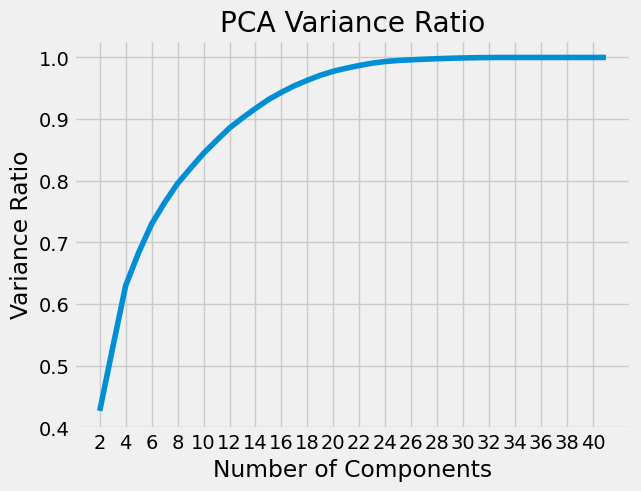

In [7]:
#Useful graph for visualization of ratio changes
plt.style.use('fivethirtyeight')
pca_fig, ax = plt.subplots()
ax.plot(range(2,len(df.columns)), variance_list)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('PCA Variance Ratio')
pca_fig.savefig('../images/PCA_Variance_Ratio.png')

In [8]:
from numpy import diff
diff_variance = diff(variance_list)
print(diff_variance)

[1.02641658e-01 1.00663585e-01 5.34947473e-02 4.63030588e-02
 3.46227387e-02 3.09975879e-02 2.47919354e-02 2.40981855e-02
 2.09197212e-02 2.01633993e-02 1.64409135e-02 1.52137169e-02
 1.44909014e-02 1.17337180e-02 1.06610149e-02 8.88703345e-03
 8.09292859e-03 6.52335675e-03 4.98348903e-03 4.37646134e-03
 3.77106046e-03 2.66239157e-03 1.71649377e-03 1.06517323e-03
 9.20502607e-04 8.44022000e-04 7.20357369e-04 5.16426966e-04
 3.87009561e-04 2.77913448e-04 1.10315280e-04 1.78766813e-05
 5.43762981e-07 8.39166345e-08 5.53464985e-09 4.00278799e-09
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


This calculates the difference between consecutive elements in the variance_list array. Slope calculus, used to determine the "elbow point" in PCA which is where the rate of variance slows down

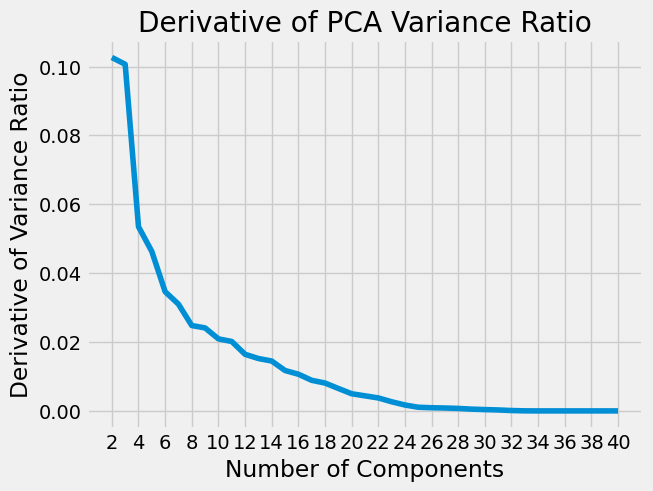

In [9]:
pca_deriv, ax = plt.subplots()
ax.plot(range(2, len(df.columns) - 1), diff_variance)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Derivative of Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('Derivative of PCA Variance Ratio')
pca_deriv.savefig('../images/PCA_Derivative.png')

Good data should have a high PCA Variance Ratio along with a low Derivative of the Variance Ratio. By using both criteria, you balance data representativeness (high variance ratio) and computational efficiency (low derivative).

In [10]:
n_comp = 16
pca = PCA(n_components=n_comp)

# Reducing the dimensions of the data
components = pca.fit_transform(x)

pca_df = pd.DataFrame(data = components, columns = [f'PC{i}' for i in range(1, n_comp + 1)])

pca_df['PLAYER'] = dfPlayerCol['PLAYER']
pca_df = pca_df[['PLAYER'] + [f'PC{i}' for i in range(1, n_comp + 1)]]
pca_df

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.21669186 0.21019781 0.10264166 0.10066358 0.05349475 0.04630306
 0.03462274 0.03099759 0.02479194 0.02409819 0.02091972 0.0201634
 0.01644091 0.01521372 0.0144909  0.01173372]
0.9434655358219793


In [11]:
x = np.column_stack([pca_df[f'PC{i}'] for i in range(1, n_comp)])

# We want a high silhouette score along with meaningful analysis
silhouette = []

for n_clusters in range(2, 32):
    kmeans = KMeans(n_clusters=n_clusters, random_state = 4)
    cluster_labels = kmeans.fit_predict(x)
    centers = kmeans.cluster_centers_
    score = silhouette_score(x, cluster_labels)
    silhouette.append(score)
    print(f"Silhouette Score with {n_clusters} clusters: {score}")

Silhouette Score with 2 clusters: 0.15146765362525438
Silhouette Score with 3 clusters: 0.18892606982536844
Silhouette Score with 4 clusters: 0.13316849402041078
Silhouette Score with 5 clusters: 0.13001394235290475
Silhouette Score with 6 clusters: 0.12680530966611467
Silhouette Score with 7 clusters: 0.12339440798927225
Silhouette Score with 8 clusters: 0.11437146602911342
Silhouette Score with 9 clusters: 0.10979145465769717
Silhouette Score with 10 clusters: 0.10266594103087034
Silhouette Score with 11 clusters: 0.09802139310909827


Silhouette Score with 12 clusters: 0.10063191944628155
Silhouette Score with 13 clusters: 0.0987487292292855
Silhouette Score with 14 clusters: 0.0956974245875398
Silhouette Score with 15 clusters: 0.09458687256122238
Silhouette Score with 16 clusters: 0.09276444308441811
Silhouette Score with 17 clusters: 0.0933607582183531
Silhouette Score with 18 clusters: 0.08722767475734554
Silhouette Score with 19 clusters: 0.08371677274958582
Silhouette Score with 20 clusters: 0.0848367581822863
Silhouette Score with 21 clusters: 0.08339168330895964
Silhouette Score with 22 clusters: 0.08349032041994459
Silhouette Score with 23 clusters: 0.08279649533200681
Silhouette Score with 24 clusters: 0.08360103441561642
Silhouette Score with 25 clusters: 0.08081304207484964
Silhouette Score with 26 clusters: 0.0806047593032618
Silhouette Score with 27 clusters: 0.07872682844392359
Silhouette Score with 28 clusters: 0.07549170807843086
Silhouette Score with 29 clusters: 0.07435331695786791
Silhouette Scor

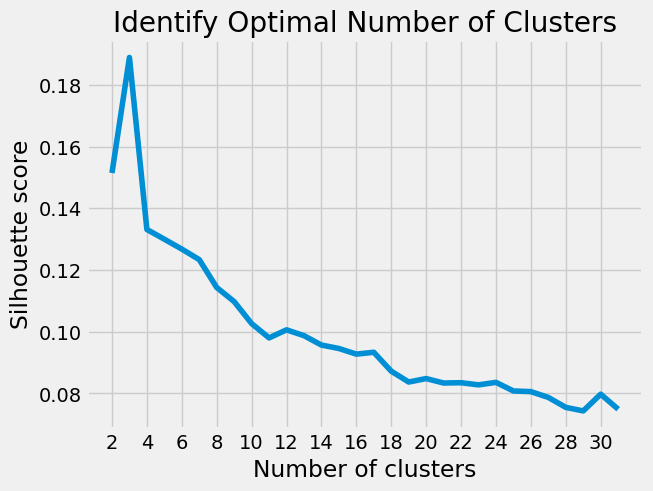

In [12]:
plt.style.use('fivethirtyeight')
silhouette_fig, ax = plt.subplots()
ax.plot(range(2,2 + len(silhouette)), silhouette)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_xticks(np.arange(2, 2+len(silhouette), 2))
ax.set_title('Identify Optimal Number of Clusters')
silhouette_fig.savefig('../images/Optimal_Clusters.png')

In [13]:
silhouette_diff = []

for i in range(1, len(silhouette)):
    improvement = 1 - ((1-silhouette[i]) / (1 - silhouette[i - 1]))
    silhouette_diff.append(improvement)
    print(f"for n_cluseter = {i + 2}, improvement = {improvement}") 

for n_cluseter = 3, improvement = 0.044144947873997586
for n_cluseter = 4, improvement = -0.06874536799987219
for n_cluseter = 5, improvement = -0.0036391751404341033
for n_cluseter = 6, improvement = -0.003688142653076376
for n_cluseter = 7, improvement = -0.0039062327274781428
for n_cluseter = 8, improvement = -0.010293046316830257
for n_cluseter = 9, improvement = -0.005171481265267008
for n_cluseter = 10, improvement = -0.008004319509297586
for n_cluseter = 11, improvement = -0.005175940749543972
for n_cluseter = 12, improvement = 0.0028942220106324967
for n_cluseter = 13, improvement = -0.0020939037727876197
for n_cluseter = 14, improvement = -0.003385631444531967
for n_cluseter = 15, improvement = -0.0012280757088531935
for n_cluseter = 16, improvement = -0.0020128153895442313
for n_cluseter = 17, improvement = 0.0006572880983218843
for n_cluseter = 18, improvement = -0.006764634904788958
for n_cluseter = 19, improvement = -0.0038464159250515273
for n_cluseter = 20, improvement =

C:\conda_tmp\ipykernel_27152\1289475222.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


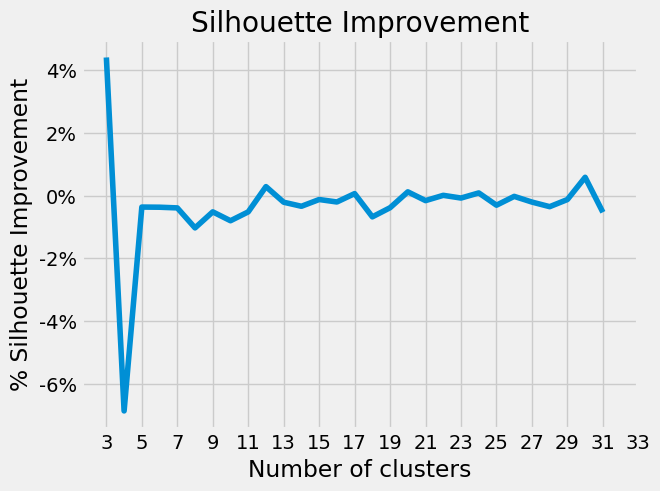

In [14]:
plt.style.use('fivethirtyeight')
silhouette_improvement_fig, ax = plt.subplots()
ax.plot(range(3, 2 + len(silhouette)), silhouette_diff)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('% Silhouette Improvement')
ax.set_xticks(np.arange(3, 4 + len(silhouette), 2))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_title('Silhouette Improvement')
silhouette_fig.savefig('../images/Silhouette_Improvement.png')

In [15]:
kmeans = KMeans(n_clusters = 15, random_state = 4)

kmeans.fit(x)

y_kmeans = kmeans.predict(x)
with open("../models/clusterMode.sav", 'wb') as f:
    pickle.dump(kmeans, f)

In [16]:
df_cluster = pd.DataFrame()

df_cluster['Player'] = dfPlayerCol['PLAYER']
df_cluster['Cluster'] = y_kmeans
df_cluster.head()

,Player,Cluster
0,deni avdija,8
1,amir coffey,3
2,jalen wilson,3
3,julian strawther,11
4,luguentz dort,13


In [17]:
df_cluster.columns = df_cluster.columns.str.upper()
for _, row in df_cluster.iterrows():
    existing_player = session.query(ClusteredPlayers).filter_by(PLAYER=row['PLAYER']).first()
    if existing_player:
        # Update the cluster value if the player exists
        existing_player.CLUSTER = row['CLUSTER']
    else:
        # Convert the row to a dictionary and pass it to the model
        clustered_player = ClusteredPlayers(
            PLAYER=row['PLAYER'],
            CLUSTER=row['CLUSTER']
        )
        session.add(clustered_player)
session.commit()

session.close()